In this notebook we consider SDEs

$$\mathrm{d} Y^k = A^k_{i\gamma}Y^i \circ \mathrm{d}W^\gamma + B^k_iY^i \mathrm{d}t, \qquad Y_0 = y_0, $$

whose mean can be calculated by the as the solution to an ODE for $\mathbb E Y$ obtained by converting to Itô and taking expectations: $$\mathbb E Y_1^k = \int \bigg(\frac 12 \sum_{\gamma = 1}^d A^k_{i \gamma} A^i_{j \gamma} \mathbb E Y_t^j + B^k_i \mathbb E Y^i \bigg)\mathrm{d} t .$$

We compute the error between the solution to this ODE for the mean, solved at a very high accuracy, and the mean of the SDE computed via cubature of degrees 3, 5 and 7 on grids of various sizes. The dimension of the noise is taken to be 3 plus optional drift. The novel degree-7 cubature is limited to a grid of size 3 for reasons of memory.

In [7]:
import importlib
import jax
jax.config.update("jax_enable_x64", True) # run everything in double precision
from diffrax import *
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import utils_plots as ut
import os
import pickle
ut = importlib.reload(ut)


In [ ]:
# This will make and save the cubature formulae in enclosing folder.
# It's only necessary to run this cell if it hasn't been run on the same computer before.
# It may take a few minutes and requires ~120 MB of free space.

%run make_cubature.py

In [2]:
# Open cubature formulas

with open("degree_3.pkl", "rb") as f:
    cubature_3 = pickle.load(f)
    
with open("degree_5.pkl", "rb") as f:
    cubature_5 = pickle.load(f)

with open("degree_7.pkl", "rb") as f:
    cubature_7 = pickle.load(f)
    
points_3, weights_3 = cubature_3[0][:4], cubature_3[1]
points_5, weights_5 = cubature_5[0][:6], cubature_5[1]
points_7, weights_7 = cubature_7[0], cubature_7[1]


In [ ]:
# Sample equations WITH drift

e, d = 2, 3
num_eqs = 10

seed = int.from_bytes(os.urandom(5), "little")
base_key = jax.random.PRNGKey(seed)
keys = jax.random.split(base_key, num_eqs)
triples_with_drift = [ut.make_triple(e, d, k) for k in keys]

true_means = [ut.mean_ODE(y0, A, B) for (y0, A, B) in triples_with_drift]

c3_with_drift = lambda m: ut.avg_err(m, points_3, weights_3, triples_with_drift, true_means)
c5_with_drift = lambda m: ut.avg_err(m, points_5, weights_5, triples_with_drift, true_means)
c7_with_drift = lambda m: ut.avg_err(m, points_7, weights_7, triples_with_drift, true_means)

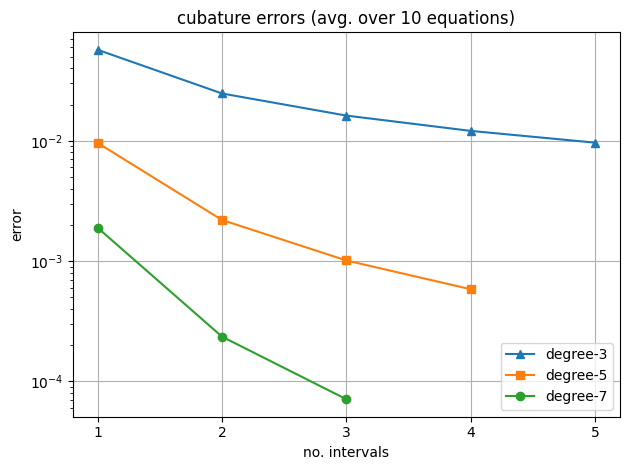

In [9]:
# This takes up to 15 minutes on a 2021 macbook pro. It needs at least 8 GB of RAM to run.

ut.plot_functions([c3_with_drift, c5_with_drift, c7_with_drift], [5, 4, 3], labels=["degree-3", "degree-5", "degree-7"], title="cubature errors (avg. over 10 equations)",
                   xlabel="no. intervals", ylabel="error", scale="log")

In [10]:
# Sample equations WITHOUT drift

e, d = 2, 3
num_eqs = 10

seed = int.from_bytes(os.urandom(5), "little")
base_key = jax.random.PRNGKey(seed)
keys = jax.random.split(base_key, num_eqs)
triples_no_drift = [ut.make_triple(e, d, k, drift = False) for k in keys]

true_means = [ut.mean_ODE(y0, A, B) for (y0, A, B) in triples_no_drift]

c3_no_drift = lambda m: ut.avg_err(m, points_3, weights_3, triples_no_drift, true_means)
c5_no_drift = lambda m: ut.avg_err(m, points_5, weights_5, triples_no_drift, true_means)
c7_no_drift = lambda m: ut.avg_err(m, points_7, weights_7, triples_no_drift, true_means)

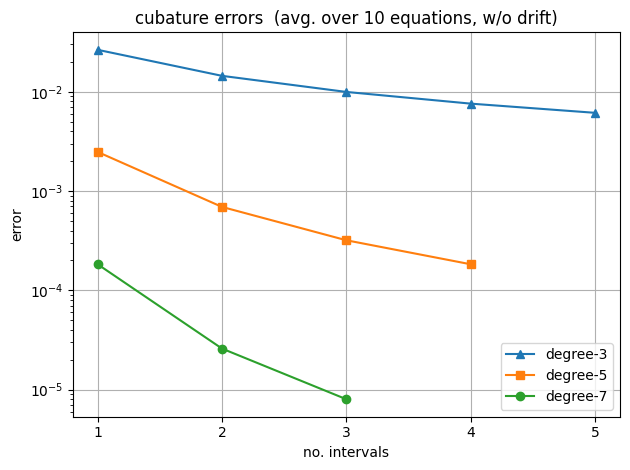

In [11]:
# This takes up to 15 minutes on a 2021 macbook pro. It needs at least 8 GB of RAM to run.

ut.plot_functions([c3_no_drift, c5_no_drift, c7_no_drift], [5, 4, 3], labels=["degree-3", "degree-5", "degree-7"], title="cubature errors  (avg. over 10 equations, w/o drift)",
                   xlabel="no. intervals", ylabel="error", scale="log")